# Kaza Riski Tahminleme Projesi (Playground Series S5E10)

Bu çalışmanın amacı, verilen yol ve çevre koşullarına dayanarak **kaza riskini (accident_risk)** tahmin etmektir.

**İçerik:**
1. Veri Yükleme ve İlk İnceleme
2. Keşifçi Veri Analizi (EDA)
3. Aykırı Değer (Outlier) Temizliği
4. Görselleştirme ve Korelasyon Analizi

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


### 1. Veri Yükleme ve Hazırlık
Analiz sürecine başlamadan önce, oluşturacağımız grafiklerin daha okunaklı ve estetik görünmesi için genel görselleştirme ayarlarını (stil ve boyut) yapılandırıyoruz.

Ardından, model geliştirme sürecinde kullanacağımız veri setlerini yüklüyoruz:
* **train.csv:** Modeli eğitmek için kullanacağımız, hedef değişkeni içeren ana veri seti.
* **test.csv:** Modelin performansını deneyeceğimiz ve tahmin üreteceğimiz veri seti.
* **sample_submission.csv:** Yarışma formatına uygun çıktı üretebilmek için örnek dosya.

Son olarak, `shape` komutu ile veri setlerinin satır ve sütun sayılarını kontrol ederek veri büyüklüğü hakkında ilk izlenimi ediniyoruz.

In [ ]:
# Görselleştirme ayarları (Sunum için şık görünmesi adına)
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Verileri okuma (Senin kodların)
dftrain = pd.read_csv('/kaggle/input/playground-series-s5e10/train.csv')
dftest = pd.read_csv('/kaggle/input/playground-series-s5e10/test.csv')
samplesubmission = pd.read_csv('/kaggle/input/playground-series-s5e10/sample_submission.csv')

# 1. Veri Setini Tanıma
print(f"Train seti boyutu: {dftrain.shape}")
print(f"Test seti boyutu: {dftest.shape}")



Train seti boyutu: (517754, 14)
Test seti boyutu: (172585, 13)

--- Veri Tipleri ve Eksik Değerler ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  5

### Veri Yapısı ve Teknik Özellikler
Veri setindeki değişkenlerin teknik detaylarını inceliyoruz. `info()` fonksiyonu bize şunları gösterir:
* **Veri Tipleri:** Her bir sütunun sayısal (int, float) mı yoksa kategorik (object) mi olduğu.
* **Eksik Değer Kontrolü:** "Non-Null Count" değeri, toplam satır sayısından az ise o sütunda eksik veri var demektir.
* **Bellek Kullanımı:** Veri setinin RAM üzerinde ne kadar yer kapladığı.
Bu bilgiler, hangi sütunlara dönüşüm (encoding) yapmamız gerektiğini belirlememize yardımcı olur.

In [ ]:
print("\n--- Veri Tipleri ve Eksik Değerler ---")
print(dftrain.info())


--- Veri Tipleri ve Eksik Değerler ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515105 entries, 0 to 515104
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   num_lanes               515105 non-null  int64  
 1   curvature               515105 non-null  float64
 2   speed_limit             515105 non-null  int64  
 3   road_signs_present      515105 non-null  int64  
 4   public_road             515105 non-null  int64  
 5   holiday                 515105 non-null  int64  
 6   school_season           515105 non-null  int64  
 7   num_reported_accidents  515105 non-null  int64  
 8   accident_risk           515105 non-null  float64
 9   road_type_rural         515105 non-null  bool   
 10  road_type_urban         515105 non-null  bool   
 11  lighting_dim            515105 non-null  bool   
 12  lighting_night          515105 non-null  bool   
 13  weather_foggy           515105 non

### İstatistiksel Özet (Descriptive Statistics)
Veri setindeki sayısal değişkenlerin dağılımını, merkezini ve yayılımını anlamak için istatistiksel özet tablosunu inceliyoruz.

`describe()` fonksiyonu bize her bir sütun için şunları sunar:
* **Ortalama (mean) ve Standart Sapma (std):** Verilerin genel eğilimi ve ne kadar dağıldığı.
* **Min ve Max Değerleri:** Veri setindeki uç noktalar. (Örneğin; negatif hız limiti veya mantıksız derecede yüksek şerit sayısı gibi hatalı verileri buradan fark edebiliriz.)
* **Çeyreklikler (%25, %50, %75):** Verinin yığıldığı aralıklar.

Sonuna eklenen `.T` (Transpose) işlemi, tabloyu ters çevirerek (satırları sütun yaparak) okumayı kolaylaştırır.

In [ ]:

print("\n--- İstatistiksel Özet (Sayısal) ---")
print(dftrain.describe().T)


--- İstatistiksel Özet (Sayısal) ---
                           count           mean            std   min  \
id                      517754.0  258876.500000  149462.849974   0.0   
num_lanes               517754.0       2.491511       1.120434   1.0   
curvature               517754.0       0.488719       0.272563   0.0   
speed_limit             517754.0      46.112575      15.788521  25.0   
num_reported_accidents  517754.0       1.187970       0.895961   0.0   
accident_risk           517754.0       0.352377       0.166417   0.0   

                              25%        50%        75%       max  
id                      129438.25  258876.50  388314.75  517753.0  
num_lanes                    1.00       2.00       3.00       4.0  
curvature                    0.26       0.51       0.71       1.0  
speed_limit                 35.00      45.00      60.00      70.0  
num_reported_accidents       1.00       1.00       2.00       7.0  
accident_risk                0.23       0.34     

### Eksik Değer (Missing Value) Kontrolü
Veri setinde boş veya eksik (NaN) değerlerin olup olmadığını kontrol ediyoruz. Bu adım kritik öneme sahiptir çünkü:
* Çoğu makine öğrenmesi algoritması eksik verilerle çalışamaz.
* Eğer eksik veri varsa, bu boşlukları doldurma (imputation) veya ilgili satırları/sütunları silme stratejileri belirlememiz gerekir.

`isnull().sum()` komutu, her bir sütunda kaç adet eksik veri olduğunu sayarak bize raporlar.

In [ ]:
print("\n--- Eksik Değer Kontrolü ---")
print(dftrain.isnull().sum())


--- Eksik Değer Kontrolü ---
id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64


### 3. Aykırı Değer (Outlier) Analizi ve Temizliği
Veri setindeki normal dağılımın çok dışında kalan "uç değerler", modelin yanlış öğrenmesine sebep olabilir. Bu aşamada istatistiksel bir yöntemle bu gürültülü verileri temizliyoruz.

**İzlenen Adımlar:**
1.  **Görsel Tespit:** `num_lanes`, `speed_limit` ve `num_reported_accidents` sütunlarını **Boxplot (Kutu Grafiği)** ile görselleştirerek aykırı değerlerin varlığını teyit ediyoruz.
2.  **IQR (Interquartile Range) Yöntemi:**
    * Verinin %25'lik (Q1) ve %75'lik (Q3) çeyreklerini hesaplıyoruz.
    * Bu aralığı (IQR) kullanarak **Alt ve Üst Sınırlar** belirliyoruz.
    * Sınırların dışında kalan satırları veri setinden siliyoruz.

Son olarak, işlem sonrası veri kaybını raporluyor ve indeksleri sıfırlayarak veri setini modellemeye hazır hale getiriyoruz.

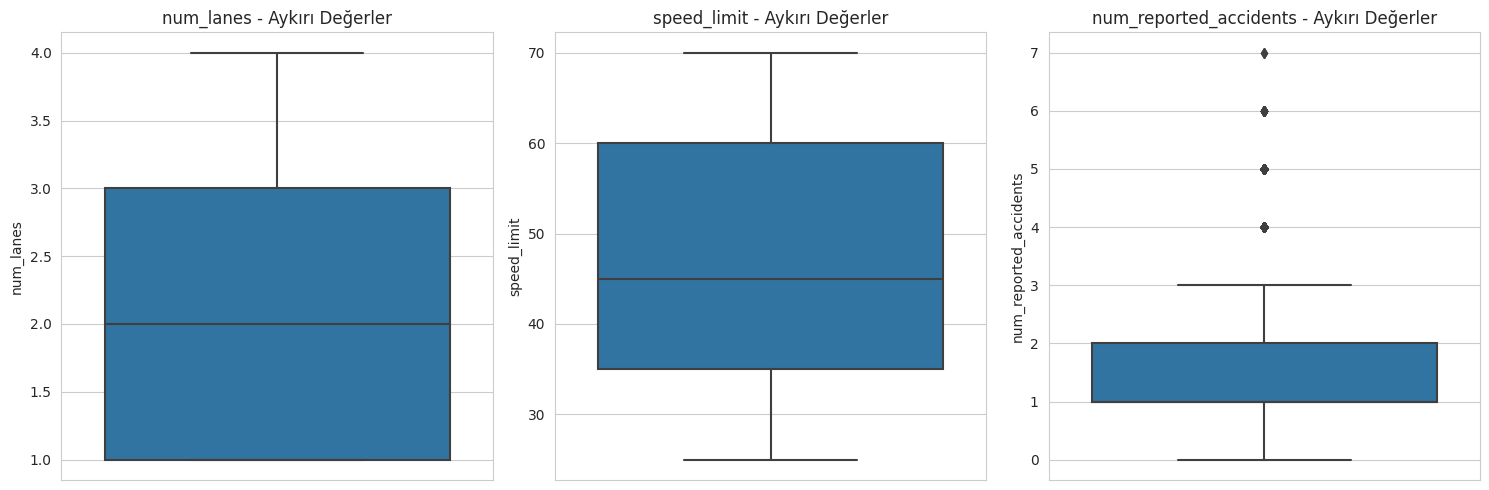


--- Temizlik Başlıyor ---
num_lanes sütunundan 0 adet aykırı değer silindi.
speed_limit sütunundan 0 adet aykırı değer silindi.
num_reported_accidents sütunundan 2649 adet aykırı değer silindi.

Toplam Veri Kaybı: 2649 satır
Kalan Veri Sayısı: 515105
Veri seti outlier'lardan arındırıldı.


In [ ]:
# --- ADIM 3: AYKIRI DEĞER (OUTLIER) ANALİZİ VE TEMİZLİĞİ ---

# Aykırı değer arayacağımız sayısal sütunlar
outlier_cols = ['num_lanes', 'speed_limit', 'num_reported_accidents']

# Önce görselleştirelim (Boxplot)
plt.figure(figsize=(15, 5))
for i, col in enumerate(outlier_cols):
    plt.subplot(1, 3, i+1)
    sns.boxplot(y=dftrain[col])
    plt.title(f'{col} - Aykırı Değerler')
plt.tight_layout()
plt.show()

# IQR Yöntemi ile Temizleme Fonksiyonu
def remove_outliers(df, columns):
    df_clean = df.copy()
    total_dropped = 0

    for col in columns:
        # Çeyreklikler (Quartiles)
        Q1 = df_clean[col].quantile(0.25)
        Q3 = df_clean[col].quantile(0.75)
        IQR = Q3 - Q1

        # Sınırlar (Alt ve Üst Limit)
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Filtreleme
        initial_count = len(df_clean)
        df_clean = df_clean[(df_clean[col] >= lower_bound) & (df_clean[col] <= upper_bound)]
        dropped_count = initial_count - len(df_clean)

        print(f"{col} sütunundan {dropped_count} adet aykırı değer silindi.")
        total_dropped += dropped_count

    return df_clean

print("\n--- Temizlik Başlıyor ---")

# Temizleme işlemini doğrudan dftrain üzerinde yapıyoruz
initial_len = len(dftrain)
dftrain = remove_outliers(dftrain, outlier_cols)
final_len = len(dftrain)

print(f"\nToplam Veri Kaybı: {initial_len - final_len} satır")
print(f"Kalan Veri Sayısı: {final_len}")

# Indexleri resetleyelim ki ilerde sorun çıkmasın
dftrain.reset_index(drop=True, inplace=True)
print("Veri seti outlier'lardan arındırıldı.")

### 6. Görselleştirme ve İlişki Analizi
Verinin yapısını daha iyi anlamak için grafiklerden faydalanıyoruz:

1.  **Hedef Değişken Analizi (Accident Risk):**
    * `accident_risk` sütununun histogramını çizdiriyoruz.
    * Bu grafik bize kaza riskinin hangi değerlerde yoğunlaştığını ve dağılımın şeklini (örneğin; normal dağılım mı, sağa/sola çarpık mı) gösterir.

2.  **Korelasyon Matrisi (Heatmap):**
    * Sadece sayısal sütunları seçerek birbirleriyle olan ilişkilerini inceliyoruz.
    * **Isı Haritası (Heatmap):** Kırmızıya yakın renkler güçlü pozitif ilişkiyi (biri artarken diğeri de artıyor), maviye yakın renkler ise negatif ilişkiyi gösterir.
    * Bu analiz, hangi özelliklerin (feature) kaza riskini daha çok etkilediğini keşfetmemizi sağlar.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


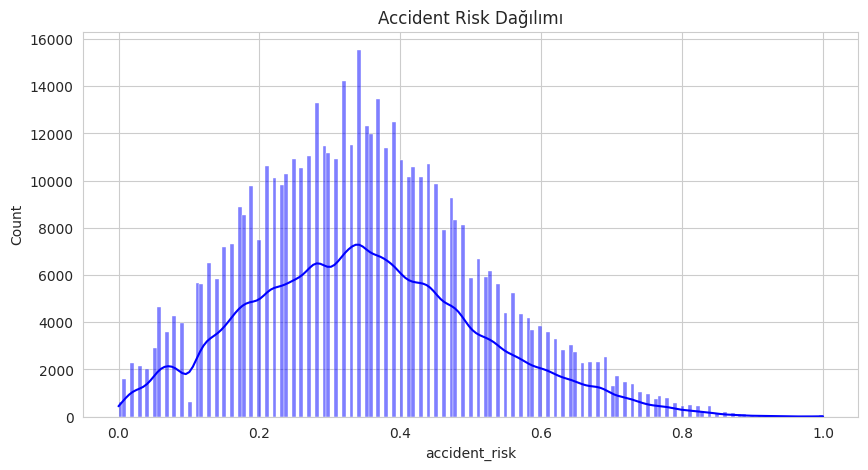

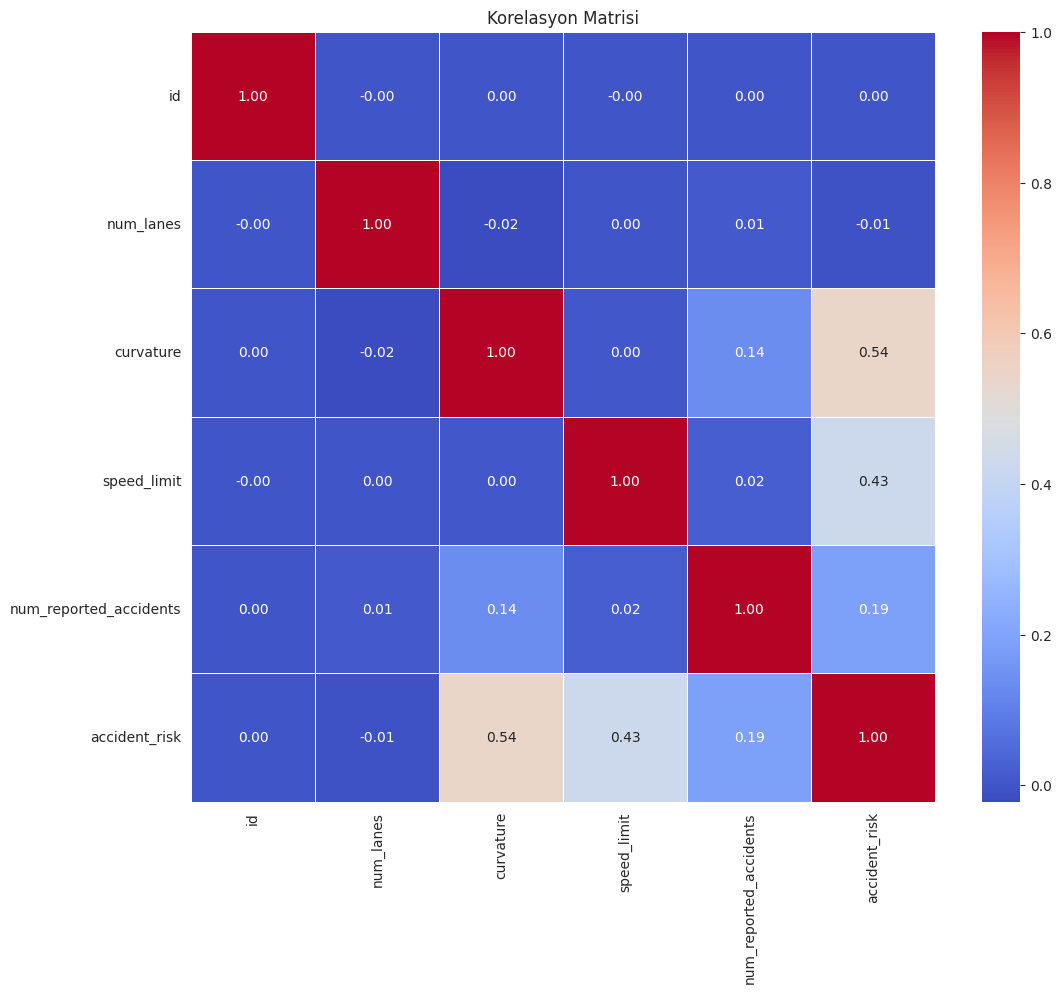

In [ ]:
# 2. Hedef Değişken Dağılımı (Accident Risk)
plt.figure(figsize=(10, 5))
sns.histplot(dftrain['accident_risk'], kde=True, color='blue')
plt.title('Accident Risk Dağılımı')
plt.show()

# 3. Korelasyon Matrisi (Sayısal Değişkenler İçin)
# Sadece sayısal sütunları seçiyoruz
numeric_cols = dftrain.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 10))
corr_matrix = dftrain[numeric_cols].corr()

# Isı haritası (Heatmap)
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Korelasyon Matrisi')
plt.show()

### 7. Kategorik Değişken Analizi
Sayısal verilerin ardından, metin tabanlı kategorik özelliklerin (`road_type`, `weather` vb.) kaza riski üzerindeki etkisini inceliyoruz.

* **Çoklu Grafik (Subplots):** Tüm kategorik değişkenleri tek seferde görebilmek için 3x2'lik bir grafik ızgarası oluşturuyoruz.
* **Boxplot Analizi:** Her bir kategori için kaza riskinin nasıl dağıldığını (medyan, çeyreklikler) karşılaştırıyoruz.
    * *Örneğin:* "Yağmurlu havada kaza riski, güneşli havaya göre daha mı yüksek?" sorusunun cevabını bu grafiklerde arıyoruz.
* **Görsel Düzenleme:** Eksen yazılarını (tick_params) 45 derece eğerek okunabilirliği artırıyoruz.

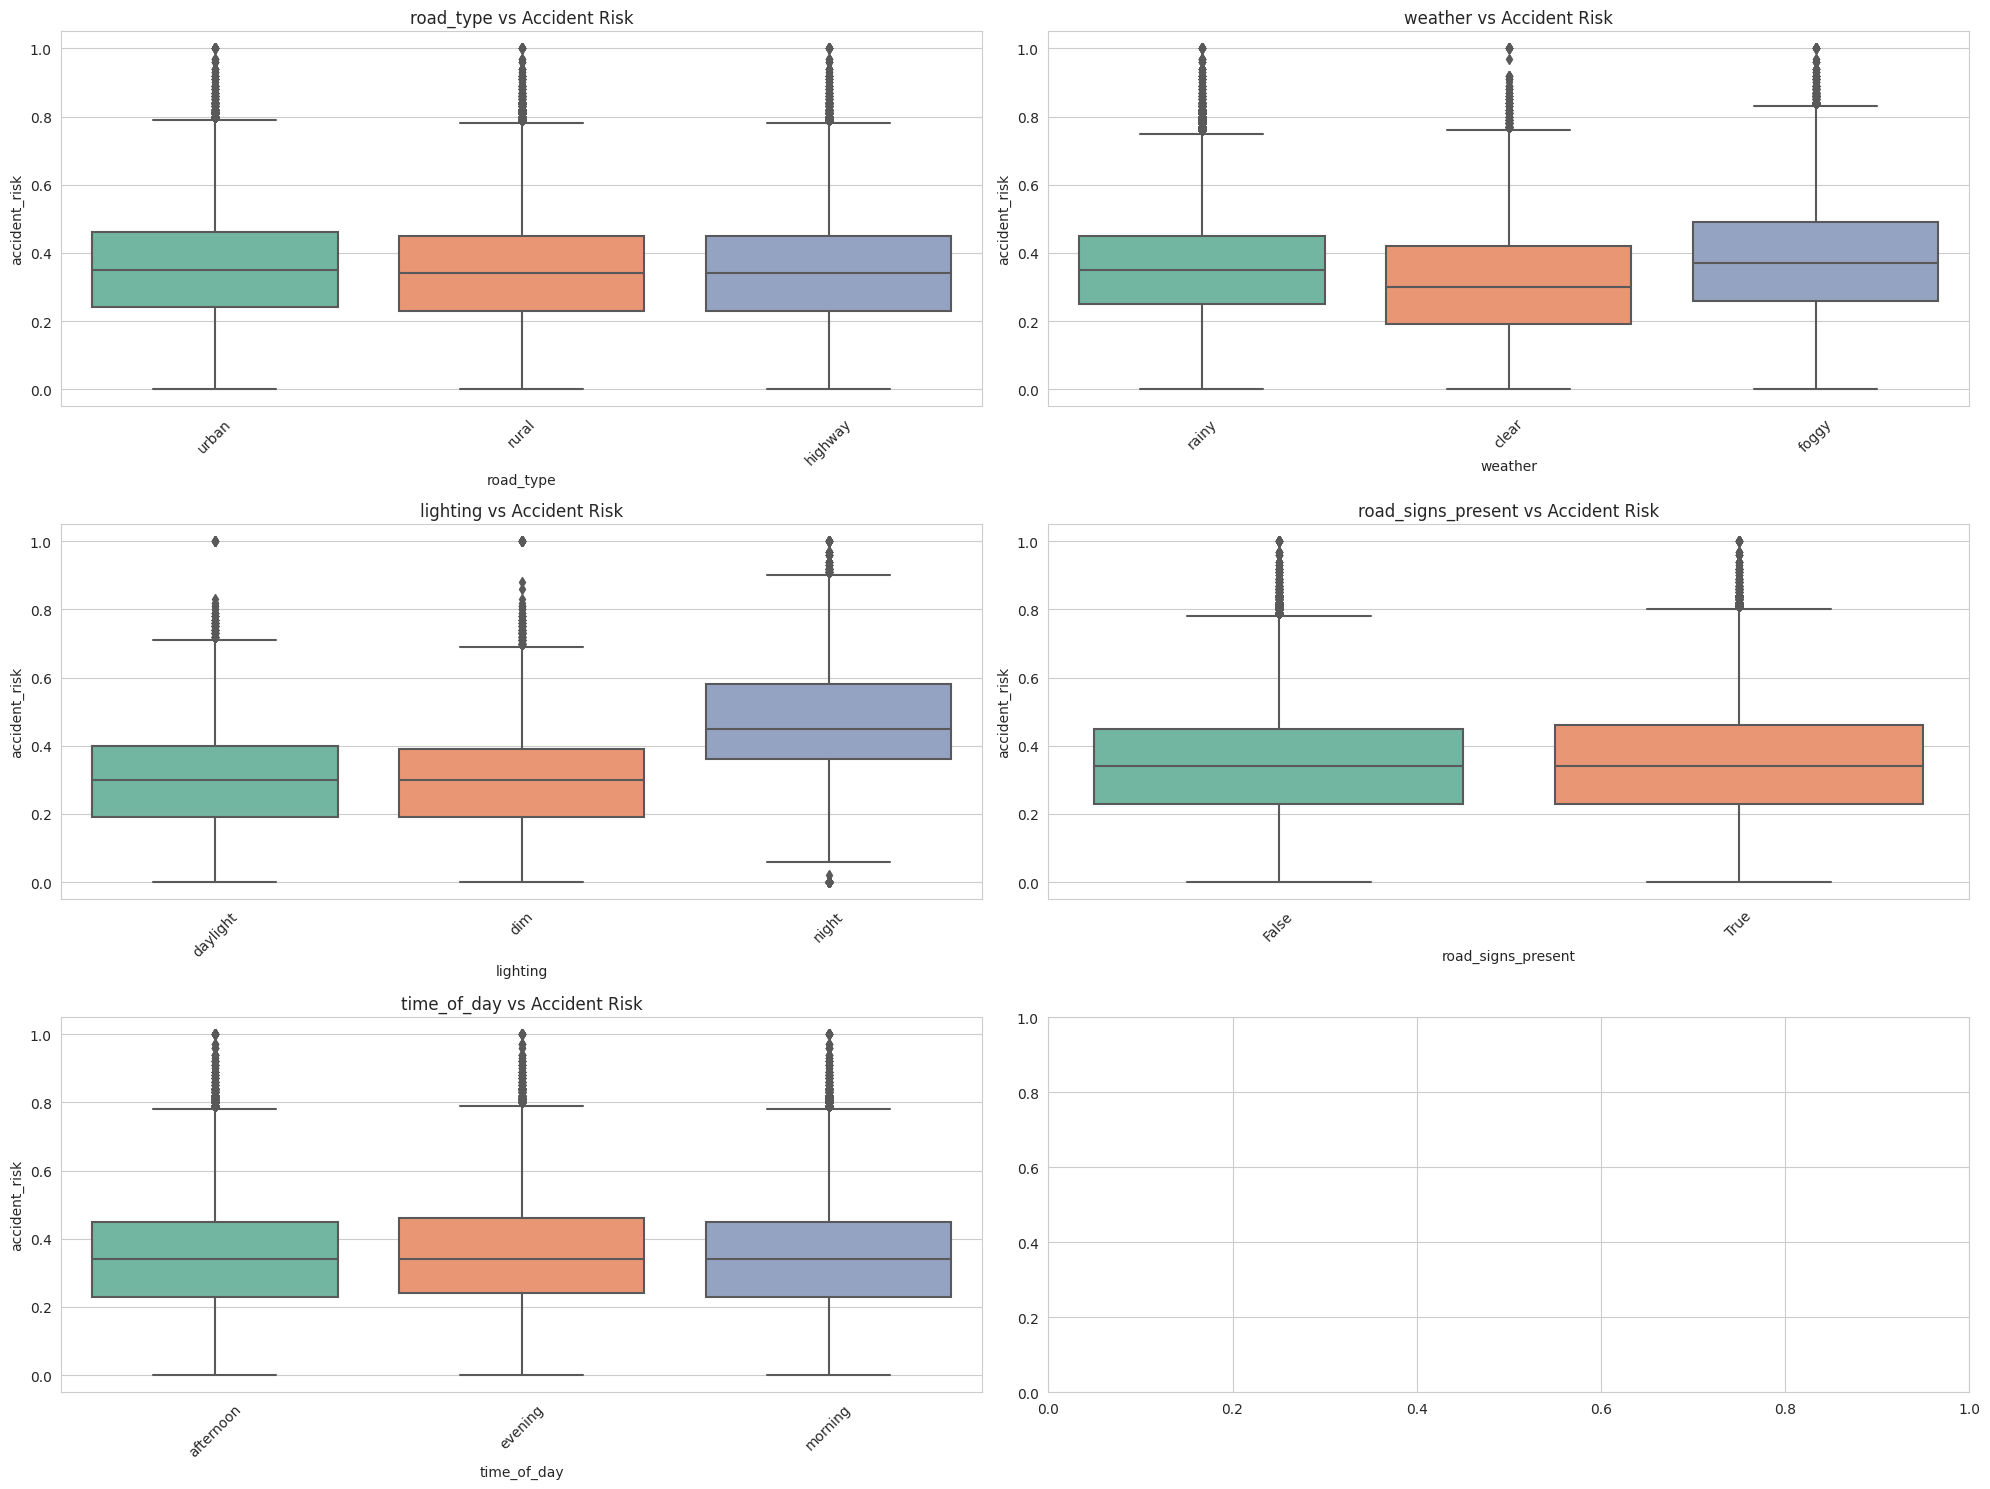

In [ ]:
# Kategorik sütunları belirleyelim (Object tipindekiler)
cat_cols = ['road_type', 'weather', 'lighting', 'road_signs_present', 'time_of_day']

fig, axes = plt.subplots(3, 2, figsize=(20, 15)) # Çoklu grafik alanı
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    if i < len(axes):
        # Kategorik değişkene göre riskin kutu grafiği
        sns.boxplot(data=dftrain, x=col, y='accident_risk', ax=axes[i], palette="Set2")
        axes[i].set_title(f'{col} vs Accident Risk')
        axes[i].tick_params(axis='x', rotation=45) # Yazılar sığsın diye eğdik

plt.tight_layout()
plt.show()

### 8. Veri Ön İşleme (Preprocessing)
Ham veriyi makine öğrenmesi modellerine uygun hale getirmek için gerekli dönüşümleri yapıyoruz.

**Uygulanan Adımlar:**
1.  **ID Ayrıştırma:** `id` sütunu modelin öğrenmesi gereken bir özellik olmadığı için (sadece kayıt numarasıdır) eğitim setinden çıkarılır.
2.  **Boolean Dönüşümü:** `True/False` şeklindeki mantıksal değerler, bilgisayarın işleyebileceği `1/0` sayısal formatına çevrilir.
3.  **One-Hot Encoding:** Kategorik veriler (örn: 'Rainy', 'Sunny'), her biri ayrı bir sütun olacak şekilde 0 ve 1'lere dönüştürülür (`pd.get_dummies`). `drop_first=True` kullanılarak gereksiz çoklu bağlantı (multicollinearity) önlenir.
4.  **Train-Test Eşitleme (Alignment):** **(Kritik Adım)** Train setinde oluşan bir dummy değişkenin (örn: çok nadir bir hava durumu) Test setinde hiç olmaması modelin hata vermesine neden olabilir. `align` fonksiyonu ile her iki veri setinin sütun yapısını birebir eşitliyoruz; eksik olanlara 0 atıyoruz.

In [ ]:
# --- ADIM 2: VERİ ÖN İŞLEME (PREPROCESSING) ---

# 1. ID sütununu ayıralım (Eğitimde kullanmayacağız ama test setinde submission için lazım olabilir, kenarda dursun)
train_id = dftrain['id']
test_id = dftest['id']

dftrain = dftrain.drop('id', axis=1)
dftest = dftest.drop('id', axis=1)

# 2. Boolean (True/False) Değerleri 1/0'a Çevirme
# Bu sütunlar zaten bool tipinde, bunları int yaparsak 1 ve 0 olur.
bool_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']

for col in bool_cols:
    dftrain[col] = dftrain[col].astype(int)
    dftest[col] = dftest[col].astype(int)

# 3. Kategorik Değişkenler için One-Hot Encoding (Get Dummies)
# drop_first=True: Linear Regression'da "Dummy Variable Trap" (Multicollinearity) oluşmaması için ilk kategoriyi atıyoruz.
dftrain = pd.get_dummies(dftrain, drop_first=True)
dftest = pd.get_dummies(dftest, drop_first=True)

# KRİTİK ADIM: Train ve Test sütunlarını eşitleme!
# Bazen train setinde olan bir kategori (örn: 'weather_Snow') test setinde hiç olmayabilir.
# Bu durumda sütun sayıları tutmaz ve model hata verir. Bunu engellemek için "align" kullanıyoruz.
# join='left' diyerek train setindeki sütun yapısını koruyoruz, testte olmayanlara 0 basıyoruz.
final_train, final_test = dftrain.align(dftest, join='left', axis=1, fill_value=0)

# final_test içinde 'accident_risk' sütunu NaN olarak gelecektir (çünkü test setinde bu yoktu), onu çıkaralım.
if 'accident_risk' in final_test.columns:
    final_test = final_test.drop('accident_risk', axis=1)

print("İşlem sonrası Train Boyutu:", final_train.shape)
print("İşlem sonrası Test Boyutu:", final_test.shape)

# Son kontrol
print("\nYeni Sütunlar (İlk 5):")
print(final_train.columns[:10]) # Sadece ilk 10 tanesini görelim

İşlem sonrası Train Boyutu: (515105, 17)
İşlem sonrası Test Boyutu: (172585, 16)

Yeni Sütunlar (İlk 5):
Index(['num_lanes', 'curvature', 'speed_limit', 'road_signs_present',
       'public_road', 'holiday', 'school_season', 'num_reported_accidents',
       'accident_risk', 'road_type_rural'],
      dtype='object')


### 9. Modelleme Hazırlığı: Eğitim ve Doğrulama Setlerinin Ayrılması
Modeli eğitmeden önce veriyi uygun parçalara bölmemiz gerekir. Bu adım, modelin ezber yapıp yapmadığını (overfitting) anlamak için hayati önem taşır.

**Yapılan İşlemler:**
1.  **X ve y Ayrımı:**
    * **X (Bağımsız Değişkenler):** Modelin öğrenirken kullanacağı girdiler (Yol tipi, hava durumu, hız limiti vb.).
    * **y (Hedef Değişken):** Modelin tahmin etmeye çalışacağı çıktı (`accident_risk`).
2.  **Train-Validation Split:**
    * Veri setinin **%80'ini** modeli eğitmek için (Training Set) kullanıyoruz.
    * Geriye kalan **%20'lik** kısmı ise modelin daha önce hiç görmediği bir veri üzerinde ne kadar başarılı olduğunu test etmek için (Validation Set) kenara ayırıyoruz.
3.  **Sonuç Listesi:** İlerleyen adımlarda deneyeceğimiz farklı modellerin performans skorlarını saklamak ve kıyaslamak için `model_results` adında boş bir liste oluşturuyoruz.

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Sonuçları saklamak için bir liste başlatalım (Sunum finali için)
model_results = []

# 1. Bağımlı (y) ve Bağımsız (X) Değişkenleri Ayırma
X = final_train.drop('accident_risk', axis=1)
y = final_train['accident_risk']

In [ ]:
# 2. Veriyi Eğitim ve Doğrulama (Validation) Setine Bölme (%20 Validation)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

### 10. Model Eğitimi ve Değerlendirme (Linear Regression)
Temel bir referans noktası (baseline) oluşturmak için en basit model olan **Doğrusal Regresyon (Linear Regression)** ile başlıyoruz.

**Adımlar:**
1.  **Model Kurulumu ve Eğitim:** `lr_model.fit` komutu ile model, eğitim verisindeki (X_train) desenleri ve hedef değişkenle (y_train) olan ilişkiyi öğrenir.
2.  **Tahmin:** Eğitilen modelden, daha önce görmediği (X_val) veriler için tahmin yapması istenir.
3.  **Performans Metrikleri:**
    * **RMSE (Root Mean Squared Error):** Tahminlerin gerçek değerlerden ortalama ne kadar saptığını gösterir. Düşük olması iyidir.
    * **R2 Score:** Modelin verideki değişkenliği ne kadar açıklayabildiğini gösterir (1'e ne kadar yakınsa o kadar iyi).
4.  **Cross Validation (Çapraz Doğrulama):**
    * Sadece tek bir train/test ayrımına güvenmek yanıltıcı olabilir (şans eseri çok kolay veya zor veriler denk gelmiş olabilir).
    * **10-Fold CV:** Veriyi 10 parçaya böler, her seferinde 9'uyla eğitip 1'iyle test eder. Bu işlemi 10 kez tekrarlayıp ortalamasını alır. Bu sayede modelin gerçek performansını çok daha güvenilir şekilde ölçmüş oluruz.
5.  **Sonuçların Kaydı:** Elde edilen tüm skorları `model_results` listesine ekleyerek, ileride deneyeceğimiz diğer modellerle (XGBoost, Random Forest vb.) kıyaslama imkanı yaratıyoruz.

In [ ]:
# 3. Modeli Kurma
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
# 4. Tahmin Yapma
y_pred = lr_model.predict(X_val)
# 5. Metrikler (RMSE ve R2)
# RMSE (Hata Kareler Ortalamasının Karekökü): Hatanın büyüklüğünü gösterir (Düşük olması iyi).
# R2 Score: Modelin varyansı açıklama oranı (1'e yakın olması iyi).
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("--- Linear Regression Sonuçları (Validation Set) ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")
# --- LINEAR REGRESSION SONUÇLARI VE CROSS VALIDATION ---

# 1. Normal Test (Validation Set)
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
r2 = r2_score(y_val, y_pred)

print("--- Linear Regression Sonuçları (Validation Set) ---")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

# 2. Cross Validation (10-Katlı)
cv_r2_scores = cross_val_score(lr_model, X, y, cv=10, scoring='r2')
cv_rmse_scores = cross_val_score(lr_model, X, y, cv=10, scoring='neg_mean_squared_error')
cv_rmse = np.sqrt(-cv_rmse_scores).mean()

print("\n--- 10-Fold Cross Validation Sonuçları ---")
print(f"CV R2 Ortalaması: {cv_r2_scores.mean():.4f}")
print(f"CV R2 Standart Sapma: {cv_r2_scores.std():.4f}")

# 3. SONUÇLARI LİSTEYE EKLEME (HATAYI ÇÖZEN KISIM BURASI)
# Önce boş bir sözlük oluşturup dolduruyoruz, sonra listeye ekliyoruz.
model_results.append({
    'Model': 'Linear Regression',
    'RMSE': rmse,
    'R2': r2,
    'CV_RMSE': cv_rmse,
    'CV_R2': cv_r2_scores.mean(),
    'CV_Std': cv_r2_scores.std()
})

print("\nSonuçlar başarıyla kaydedildi.")

LinearRegression()

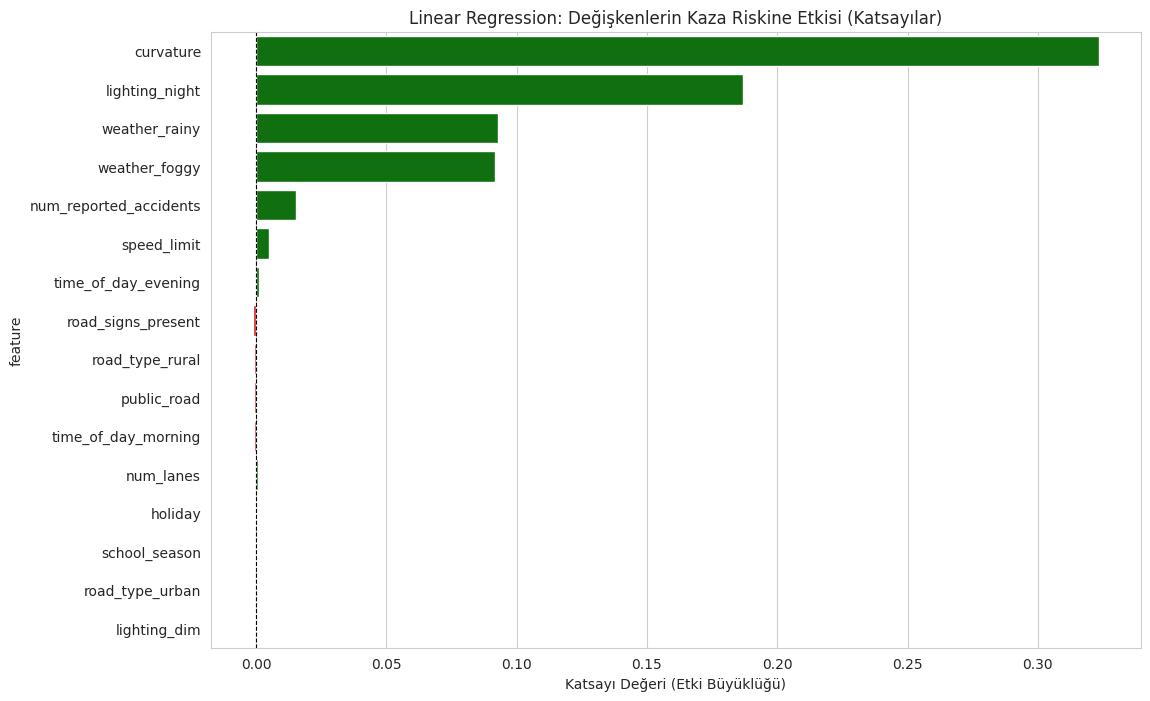


En Etkili 5 Faktör:
                   feature  coefficient
1                curvature     0.323292
11          lighting_night     0.186741
13           weather_rainy     0.092785
12           weather_foggy     0.091589
7   num_reported_accidents     0.015116


In [ ]:
# --- LINEAR REGRESSION KATSAYILARI (COEFFICIENTS) ---
# Lineer modellerde "feature importance" yerine katsayılara bakılır.

# Katsayıları bir DataFrame'e alalım
coef_df = pd.DataFrame({
    'feature': X.columns,
    'coefficient': lr_model.coef_
})

# Mutlak değere göre sıralayalım (En etkili olanlar en üstte görünsün diye)
coef_df['abs_coef'] = coef_df['coefficient'].abs()
coef_df = coef_df.sort_values('abs_coef', ascending=False)

# Görselleştirme
plt.figure(figsize=(12, 8))
# Pozitif etkileri yeşil, negatif etkileri kırmızı yapalım
colors = ['green' if x > 0 else 'red' for x in coef_df['coefficient']]

sns.barplot(x='coefficient', y='feature', data=coef_df.head(20), palette=colors)
plt.title('Linear Regression: Değişkenlerin Kaza Riskine Etkisi (Katsayılar)')
plt.xlabel('Katsayı Değeri (Etki Büyüklüğü)')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8) # 0 noktasına çizgi
plt.show()

print("\nEn Etkili 5 Faktör:")
print(coef_df[['feature', 'coefficient']].head(5))

In [ ]:
model_results

[{'Model': 'Linear Regression',
  'RMSE': 0.07341298490997669,
  'R2': 0.8002470746891811,
  'CV_RMSE': 0.07325102820848398,
  'CV_R2': 0.8014888051733907,
  'CV_Std': 0.00123824561049327}]

### 11. Gelişmiş Modeller ve Özellik Önem Düzeyi (Feature Importance)
Basit doğrusal modelden sonra, daha karmaşık veri yapılarını öğrenebilen güçlü "Ensemble" algoritmalarını devreye alıyoruz.

**Kullanılan Modeller:**
1.  **Random Forest (Rastgele Orman):** Yüzlerce karar ağacı oluşturur ve bunların tahminlerinin ortalamasını alır. Gürültülü verilere karşı dirençlidir ve genellikle tek bir ağaçtan çok daha iyi sonuç verir.
2.  **XGBoost (Extreme Gradient Boosting):** Kaggle yarışmalarının vazgeçilmezi olan bu algoritma, bir önceki ağacın yaptığı hataları düzelterek ilerler. Hız ve performans açısından oldukça verimlidir.

**Feature Importance (Hangi Özellik Daha Önemli?):**
Modelin tahmin başarısı kadar, "Neden bu tahmini yaptı?" sorusu da önemlidir.
* XGBoost modelinin iç yapısını analiz ederek, kaza riskini en çok etkileyen faktörleri (Örn: Hız limiti, yolun aydınlatması vb.) önem derecesine göre sıralayıp görselleştiriyoruz.
* Bu grafik, projenin en değerli çıktılarından biridir çünkü problemin kök nedenlerine ışık tutar.

Random Forest eğitiliyor...
Random Forest RMSE: 0.0595
Random Forest R2: 0.8686

XGBoost eğitiliyor...
XGBoost RMSE: 0.0562
XGBoost R2: 0.8831


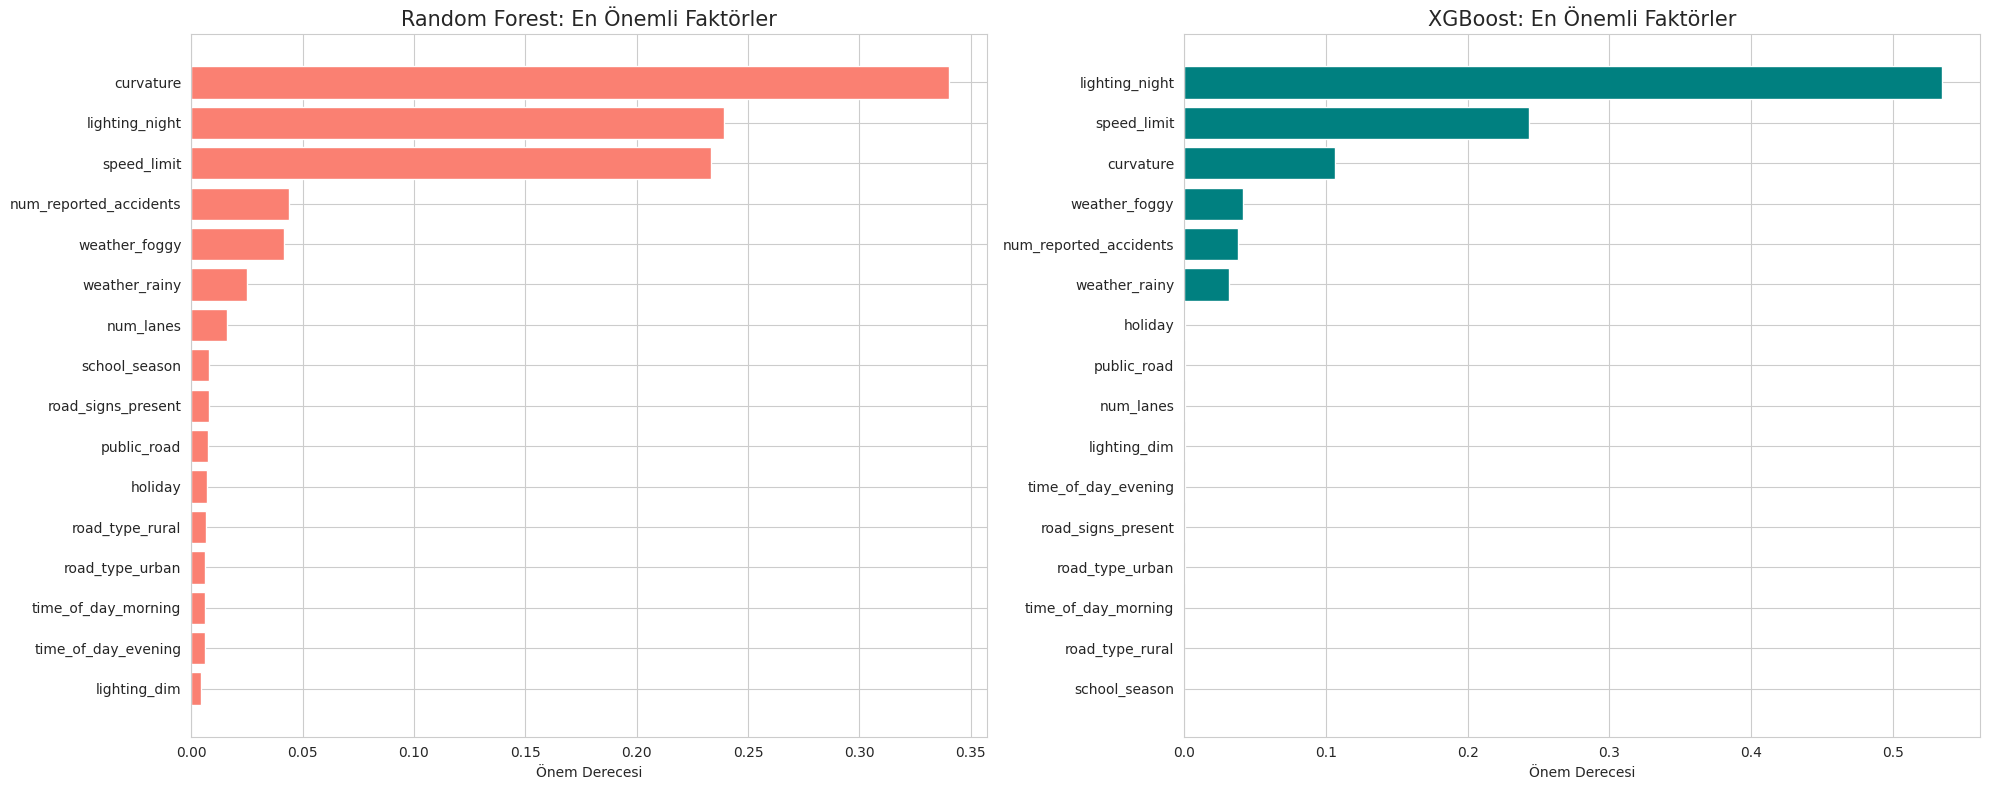

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# --- ADIM 5: GELİŞMİŞ MODELLER VE KARŞILAŞTIRMA ---

# 1. Random Forest Modeli
print("Random Forest eğitiliyor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
rf_r2 = r2_score(y_val, rf_pred)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R2: {rf_r2:.4f}")

model_results.append({
    'Model': 'Random Forest',
    'RMSE': rf_rmse,
    'R2': rf_r2,
    'CV_RMSE': 'Hesaplanmadı (Hız için)'
})

# 2. XGBoost Modeli (Gradient Boosting)
print("\nXGBoost eğitiliyor...")
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_r2 = r2_score(y_val, xgb_pred)

print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost R2: {xgb_r2:.4f}")

model_results.append({
    'Model': 'XGBoost',
    'RMSE': xgb_rmse,
    'R2': xgb_r2,
    'CV_RMSE': 'Hesaplanmadı'
})

# --- ADIM 6: FEATURE IMPORTANCE KARŞILAŞTIRMASI (RF vs XGB) ---
# İki modeli yan yana çizdirelim

fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # 1 Satır, 2 Sütunluk alan

# --- 1. Random Forest Grafiği (Sol) ---
importances_rf = rf_model.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
features_rf = X.columns

axes[0].set_title('Random Forest: En Önemli Faktörler', fontsize=15)
axes[0].barh(range(len(indices_rf[:20])), importances_rf[indices_rf[:20]], color='salmon', align='center')
axes[0].set_yticks(range(len(indices_rf[:20])))
axes[0].set_yticklabels([features_rf[i] for i in indices_rf[:20]])
axes[0].set_xlabel('Önem Derecesi')
axes[0].invert_yaxis() # En önemlisi en üstte olsun

# --- 2. XGBoost Grafiği (Sağ) ---
importances_xgb = xgb_model.feature_importances_
indices_xgb = np.argsort(importances_xgb)[::-1]
features_xgb = X.columns

axes[1].set_title('XGBoost: En Önemli Faktörler', fontsize=15)
axes[1].barh(range(len(indices_xgb[:20])), importances_xgb[indices_xgb[:20]], color='teal', align='center')
axes[1].set_yticks(range(len(indices_xgb[:20])))
axes[1].set_yticklabels([features_xgb[i] for i in indices_xgb[:20]])
axes[1].set_xlabel('Önem Derecesi')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

feature bias riski şüphesi olduğu için en yüksek güclü öznitelik çıkaralım

### 12. Senaryo Analizi: Belirli Bir Özelliğin Etkisi (Feature Ablation)
Bazen bir özelliğin model üzerindeki gerçek etkisini görmek veya modelde gürültüye (noise) sebep olup olmadığını anlamak için o özelliği çıkarıp modeli tekrar eğitiriz.

**Bu Adımda Yapılanlar:**
1.  **Özellik Çıkarımı:** Hipotez olarak `lighting_Night` (Gece aydınlatması) sütununu veri setinden çıkarıyoruz.
2.  **Adil Karşılaştırma:** Veriyi tekrar bölerken `random_state=42` kullanmaya özen gösteriyoruz. Bu sayede ilk modelle birebir aynı satırların eğitim ve test kümesine düştüğünden emin olup, sonucun şanstan değil özellik değişiminden kaynaklandığını garanti ediyoruz.
3.  **Katsayı Görselleştirmesi:** Linear Regression modelinin katsayılarını (Coefficients) inceliyoruz:
    * **Yeşil Barlar (Pozitif):** Kaza riskini artıran faktörler.
    * **Kırmızı Barlar (Negatif):** Kaza riskini azaltan faktörler.
Bu analiz, modelin mantığını insan gözüyle yorumlamamızı (Interpretability) sağlar.

Modelden çıkarılan sütun: lighting_night

--- Linear Regression Sonuçları (Lighting_Night Hariç) ---
RMSE: 0.1041
R2 Score: 0.5985
Cross Validation hesaplanıyor...
CV R2 Ortalaması: 0.5979
CV R2 Standart Sapma: 0.0026

Yeni sonuçlar başarıyla kaydedildi.


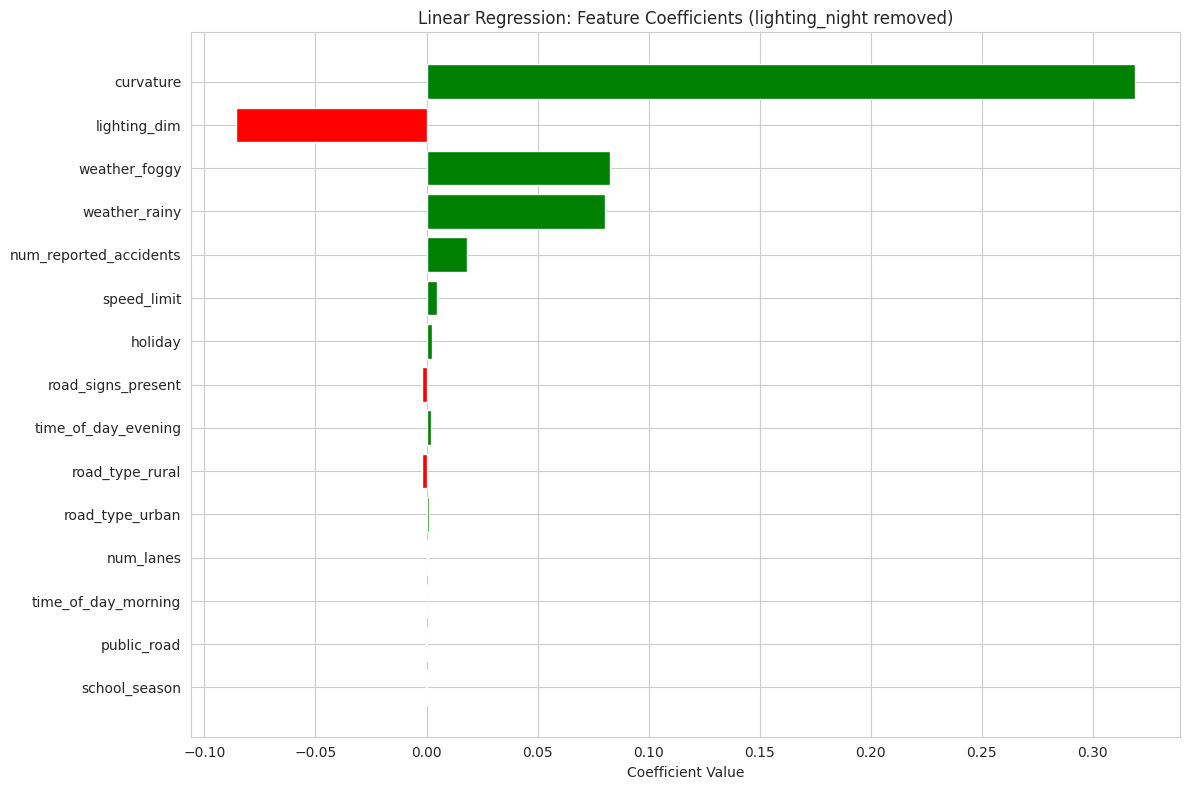

                   feature  coefficient  abs_coef
6            school_season    -0.000030  0.000030
4              public_road    -0.000196  0.000196
14     time_of_day_morning     0.000352  0.000352
0                num_lanes     0.000512  0.000512
9          road_type_urban     0.001085  0.001085
8          road_type_rural    -0.002027  0.002027
13     time_of_day_evening     0.002118  0.002118
3       road_signs_present    -0.002245  0.002245
5                  holiday     0.002427  0.002427
2              speed_limit     0.004703  0.004703
7   num_reported_accidents     0.018134  0.018134
12           weather_rainy     0.080400  0.080400
11           weather_foggy     0.082464  0.082464
10            lighting_dim    -0.085714  0.085714
1                curvature     0.318978  0.318978


In [ ]:
# --- ADIM: BELLİ BİR ÖZELLİĞİ ÇIKARIP MODELİ TEKRARLAMA ---

# 1. Çıkarılacak sütunu belirleyelim (lighting_Night olduğunu varsayıyoruz)
# Sütun ismini dinamik olarak bulalım ki hata olmasın
cols_to_drop = [col for col in X.columns if 'lighting' in col and 'night' in col]

if cols_to_drop:
    print(f"Modelden çıkarılan sütun: {cols_to_drop[0]}")

    # Sütunu X'ten atıp yeni bir X oluşturuyoruz (X_no_night)
    X_no_night = X.drop(cols_to_drop, axis=1)

    # 2. Split İşlemi (Adil karşılaştırma için aynı random_state=42 kullanıyoruz)
    X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X_no_night, y, test_size=0.2, random_state=42)

    # 3. Modeli Tekrar Kurma
    lr_model_n = LinearRegression()
    lr_model_n.fit(X_train_n, y_train_n)

    # Tahmin
    y_pred_n = lr_model_n.predict(X_val_n)

    # 4. Metrikler
    rmse_n = np.sqrt(mean_squared_error(y_val_n, y_pred_n))
    r2_n = r2_score(y_val_n, y_pred_n)

    print("\n--- Linear Regression Sonuçları (Lighting_Night Hariç) ---")
    print(f"RMSE: {rmse_n:.4f}")
    print(f"R2 Score: {r2_n:.4f}")

    # 5. Cross Validation (10-Katlı)
    # Yeni veri seti (X_no_night) üzerinde yapıyoruz
    print("Cross Validation hesaplanıyor...")
    cv_r2_scores_n = cross_val_score(lr_model_n, X_no_night, y, cv=10, scoring='r2')
    cv_rmse_scores_n = cross_val_score(lr_model_n, X_no_night, y, cv=10, scoring='neg_mean_squared_error')
    cv_rmse_n = np.sqrt(-cv_rmse_scores_n).mean()

    print(f"CV R2 Ortalaması: {cv_r2_scores_n.mean():.4f}")
    print(f"CV R2 Standart Sapma: {cv_r2_scores_n.std():.4f}")

    # 6. Sonuçları Listeye Ekleme
    model_results.append({
        'Model': 'Linear Regression (No Night)',
        'RMSE': rmse_n,
        'R2': r2_n,
        'CV_RMSE': cv_rmse_n,
        'CV_R2': cv_r2_scores_n.mean(),
        'CV_Std': cv_r2_scores_n.std()
    })

    print("\nYeni sonuçlar başarıyla kaydedildi.")

    # Görselleştirme: Feature Coefficients (lighting_night removed modeli için)
    coef_df = pd.DataFrame({
        'feature': X_no_night.columns,
        'coefficient': lr_model_n.coef_
    })
    coef_df['abs_coef'] = coef_df['coefficient'].abs()
    coef_df = coef_df.sort_values('abs_coef', ascending=True)

    plt.figure(figsize=(12, 8))
    plt.barh(coef_df['feature'], coef_df['coefficient'], color=['green' if x > 0 else 'red' for x in coef_df['coefficient']])
    plt.xlabel('Coefficient Value')
    plt.title('Linear Regression: Feature Coefficients (lighting_night removed)')
    plt.tight_layout()
    plt.show()

    print(coef_df)

else:
    print("⚠️ Uyarı: 'lighting' ve 'night' içeren bir sütun bulunamadı.")
    print("Mevcut sütunlar:")
    print(X.columns.tolist())

Modelden çıkarılan sütun: lighting_night

Random Forest (No Night) eğitiliyor...
Random Forest (No Night) RMSE: 0.0973
Random Forest (No Night) R2: 0.6492

XGBoost (No Night) eğitiliyor...
XGBoost (No Night) RMSE: 0.0906
XGBoost (No Night) R2: 0.6958


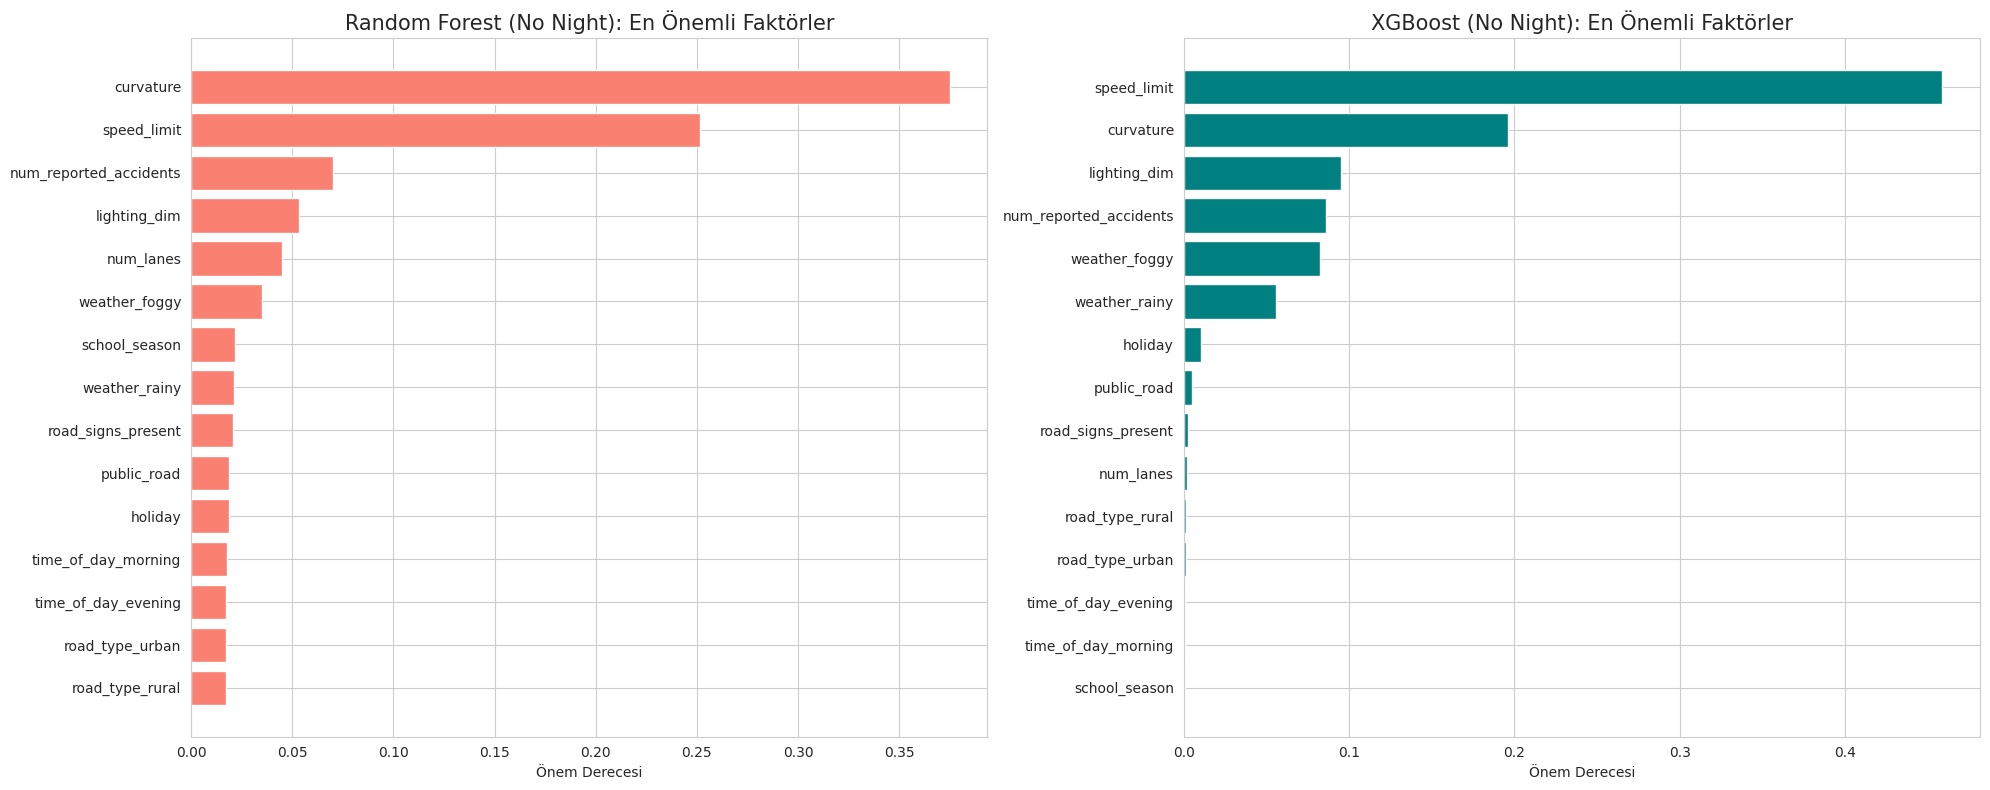

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score

# --- ADIM 7: LIGHTING_NIGHT OLMADAN GELİŞMİŞ MODELLER VE KARŞILAŞTIRMA ---

# 1. 'lighting_Night' sütununu çıkaralım (Eğer daha önce çıkarılmadıysa)
cols_to_drop = [col for col in X.columns if 'lighting' in col and 'night' in col]

if cols_to_drop:
    print(f"Modelden çıkarılan sütun: {cols_to_drop[0]}")
    X_no_night = X.drop(cols_to_drop, axis=1)

    # 2. Split İşlemi (Adil karşılaştırma için aynı random_state=42)
    X_train_n, X_val_n, y_train_n, y_val_n = train_test_split(X_no_night, y, test_size=0.2, random_state=42)

    # --- MODEL 1: Random Forest (No Night) ---
    print("\nRandom Forest (No Night) eğitiliyor...")
    rf_model_n = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
    rf_model_n.fit(X_train_n, y_train_n)
    rf_pred_n = rf_model_n.predict(X_val_n)

    rf_rmse_n = np.sqrt(mean_squared_error(y_val_n, rf_pred_n))
    rf_r2_n = r2_score(y_val_n, rf_pred_n)

    print(f"Random Forest (No Night) RMSE: {rf_rmse_n:.4f}")
    print(f"Random Forest (No Night) R2: {rf_r2_n:.4f}")

    model_results.append({
        'Model': 'Random Forest (No Night)',
        'RMSE': rf_rmse_n,
        'R2': rf_r2_n,
        'CV_RMSE': 'Hesaplanmadı'
    })

    # --- MODEL 2: XGBoost (No Night) ---
    print("\nXGBoost (No Night) eğitiliyor...")
    xgb_model_n = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
    xgb_model_n.fit(X_train_n, y_train_n)
    xgb_pred_n = xgb_model_n.predict(X_val_n)

    xgb_rmse_n = np.sqrt(mean_squared_error(y_val_n, xgb_pred_n))
    xgb_r2_n = r2_score(y_val_n, xgb_pred_n)

    print(f"XGBoost (No Night) RMSE: {xgb_rmse_n:.4f}")
    print(f"XGBoost (No Night) R2: {xgb_r2_n:.4f}")

    model_results.append({
        'Model': 'XGBoost (No Night)',
        'RMSE': xgb_rmse_n,
        'R2': xgb_r2_n,
        'CV_RMSE': 'Hesaplanmadı'
    })

    # --- ADIM 8: FEATURE IMPORTANCE KARŞILAŞTIRMASI (RF vs XGB - No Night) ---
    # lighting_Night olmadan her iki modelin de önem verdiği özellikleri yan yana görelim.

    fig, axes = plt.subplots(1, 2, figsize=(20, 8)) # 1 Satır, 2 Sütunluk alan

    # --- 1. Random Forest (No Night) Grafiği (Sol) ---
    importances_rf_n = rf_model_n.feature_importances_
    indices_rf_n = np.argsort(importances_rf_n)[::-1]
    features_rf_n = X_no_night.columns

    axes[0].set_title('Random Forest (No Night): En Önemli Faktörler', fontsize=15)
    axes[0].barh(range(len(indices_rf_n[:20])), importances_rf_n[indices_rf_n[:20]], color='salmon', align='center')
    axes[0].set_yticks(range(len(indices_rf_n[:20])))
    axes[0].set_yticklabels([features_rf_n[i] for i in indices_rf_n[:20]])
    axes[0].set_xlabel('Önem Derecesi')
    axes[0].invert_yaxis() # En önemlisi en üstte olsun

    # --- 2. XGBoost (No Night) Grafiği (Sağ) ---
    importances_xgb_n = xgb_model_n.feature_importances_
    indices_xgb_n = np.argsort(importances_xgb_n)[::-1]
    features_xgb_n = X_no_night.columns

    axes[1].set_title('XGBoost (No Night): En Önemli Faktörler', fontsize=15)
    axes[1].barh(range(len(indices_xgb_n[:20])), importances_xgb_n[indices_xgb_n[:20]], color='teal', align='center')
    axes[1].set_yticks(range(len(indices_xgb_n[:20])))
    axes[1].set_yticklabels([features_xgb_n[i] for i in indices_xgb_n[:20]])
    axes[1].set_xlabel('Önem Derecesi')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

else:
    print("Uyarı: 'lighting_Night' sütunu zaten çıkarılmış veya bulunamadı. Lütfen kontrol et.")

Bu özniteliğin çıkması mantıksız geldi ve çok büyük bir kayıp yaşadık, özniteliği geri alalım ve sonuca geçelim


Random Forest eğitiliyor...
Random Forest RMSE: 0.0595
Random Forest R2: 0.8686

XGBoost eğitiliyor...
XGBoost RMSE: 0.0562
XGBoost R2: 0.8831


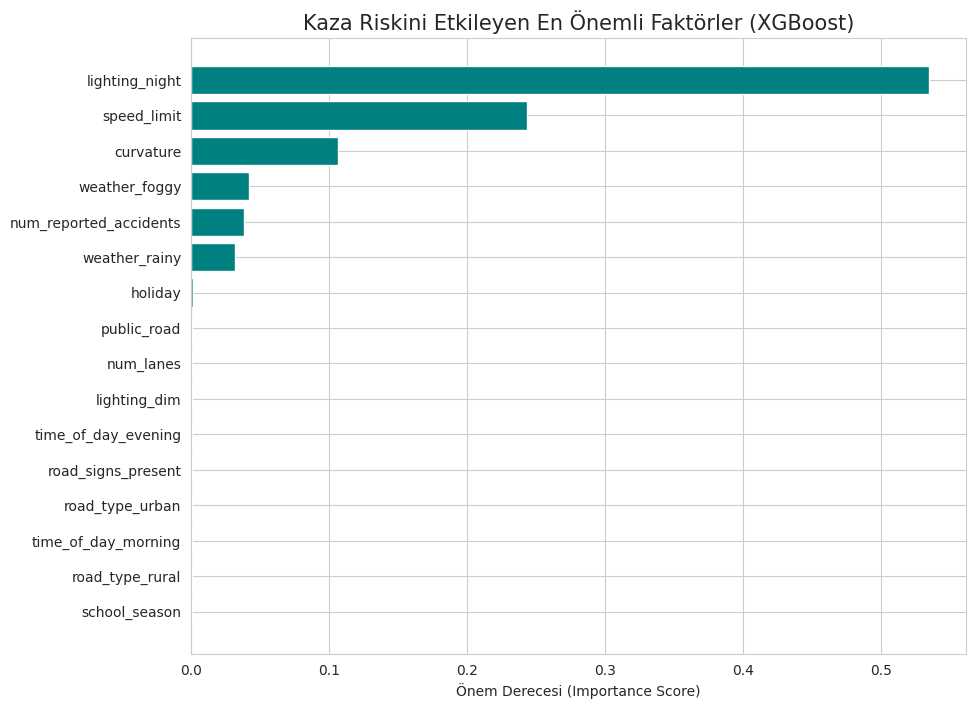

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# --- ADIM 5: GELİŞMİŞ MODELLER VE KARŞILAŞTIRMA ---

# 1. Random Forest Modeli
print("Random Forest eğitiliyor...")
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_val)

rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred))
rf_r2 = r2_score(y_val, rf_pred)

print(f"Random Forest RMSE: {rf_rmse:.4f}")
print(f"Random Forest R2: {rf_r2:.4f}")

model_results.append({
    'Model': 'Random Forest',
    'RMSE': rf_rmse,
    'R2': rf_r2,
    'CV_RMSE': 'Hesaplanmadı (Hız için)' # İstersen buraya da CV ekleyebiliriz ama süre uzar
})

# 2. XGBoost Modeli (Gradient Boosting)
print("\nXGBoost eğitiliyor...")
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

xgb_rmse = np.sqrt(mean_squared_error(y_val, xgb_pred))
xgb_r2 = r2_score(y_val, xgb_pred)

print(f"XGBoost RMSE: {xgb_rmse:.4f}")
print(f"XGBoost R2: {xgb_r2:.4f}")

model_results.append({
    'Model': 'XGBoost',
    'RMSE': xgb_rmse,
    'R2': xgb_r2,
    'CV_RMSE': 'Hesaplanmadı'
})

# --- ADIM 6: FEATURE IMPORTANCE (SUNUM İÇİN KRİTİK) ---
# Hangi özellik kaza riskini daha çok etkiliyor? (XGBoost üzerinden bakalım)

plt.figure(figsize=(10, 8))
# Özelliklerin önem derecelerini alalım
importances = xgb_model.feature_importances_
indices = np.argsort(importances)[::-1] # Büyükten küçüğe sırala
features = X.columns

# İlk 20 özelliği görselleştirelim
plt.title('Kaza Riskini Etkileyen En Önemli Faktörler (XGBoost)', fontsize=15)
plt.barh(range(len(indices[:20])), importances[indices[:20]], color='teal', align='center')
plt.yticks(range(len(indices[:20])), [features[i] for i in indices[:20]])
plt.xlabel('Önem Derecesi (Importance Score)')
plt.gca().invert_yaxis() # En önemlisi en üstte olsun
plt.show()

### 13. Final Sonuçlar ve Model Karşılaştırması
Proje boyunca eğittiğimiz tüm modellerin performans metriklerini tek bir tabloda birleştiriyoruz.

**Değerlendirme Yöntemi:**
1.  **Sonuç Tablosu:** Tüm modellerin **RMSE** (Hata) ve **R2** (Başarı) skorlarını listeleyerek sayısal bir karşılaştırma yapıyoruz.
2.  **Görsel Karşılaştırma (Bar Charts):**
    * **R2 Skoru:** Çubuğun uzun olması modelin başarısını gösterir (1'e ne kadar yakınsa o kadar iyi).
    * **RMSE Değeri:** Çubuğun kısa olması modelin daha az hata yaptığını gösterir (0'a ne kadar yakınsa o kadar iyi).
    * **Renk Kodları:** 'Night' özelliği çıkarılmış modelleri farklı renkle (Kırmızı tonları) göstererek, bu özelliğin yokluğunun performansı nasıl etkilediğini görsel olarak analiz ediyoruz.

Son olarak, R2 skoruna göre **"En İyi Modeli (Champion Model)"** otomatik olarak seçip ekrana yazdırıyoruz.

=== TÜM MODELLERİN SONUÇLARI ===

                       Model     RMSE       R2                 CV_RMSE    CV_R2   CV_Std
           Linear Regression 0.073413 0.800247                0.073251 0.801489 0.001238
Linear Regression (No Night) 0.104078 0.598520                0.104251 0.597913 0.002585
    Random Forest (No Night) 0.097284 0.649222            Hesaplanmadı      NaN      NaN
          XGBoost (No Night) 0.090593 0.695817            Hesaplanmadı      NaN      NaN
               Random Forest 0.059539 0.868615 Hesaplanmadı (Hız için)      NaN      NaN
                     XGBoost 0.056169 0.883066            Hesaplanmadı      NaN      NaN


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


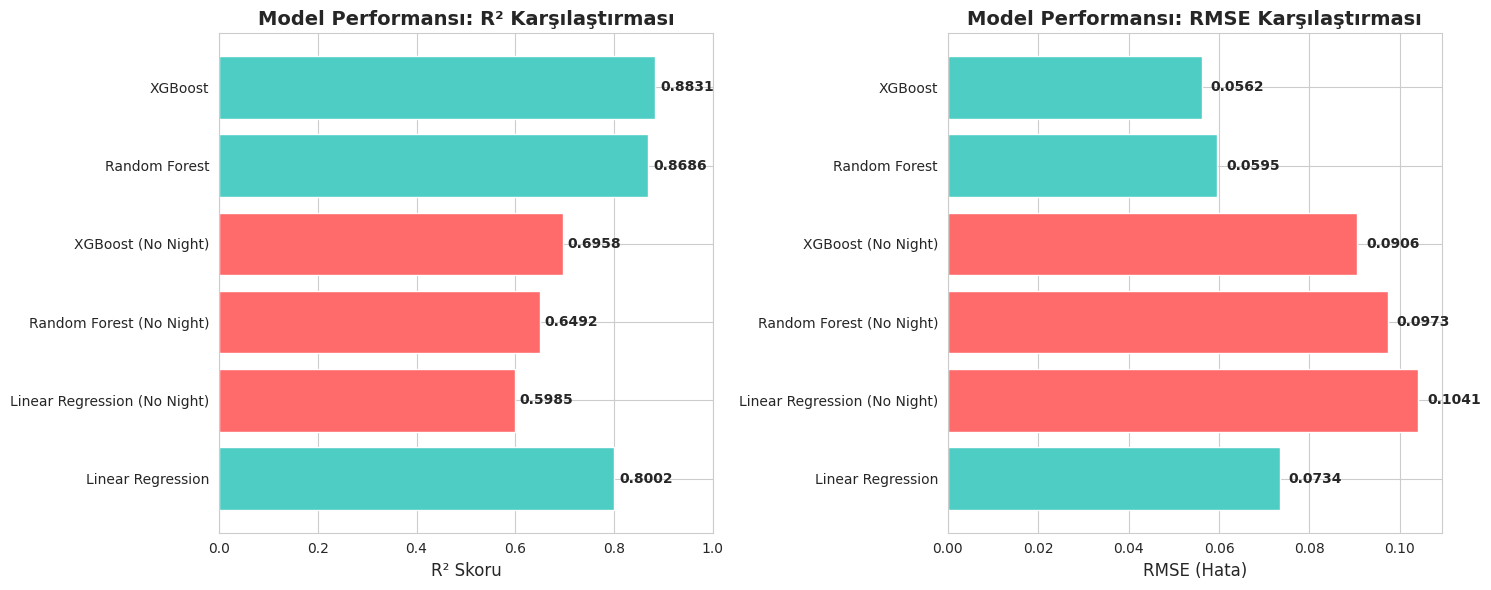


🏆 EN İYİ MODEL: XGBoost
R² Skoru: 0.8831
RMSE: 0.0562


In [ ]:
# --- EN İYİ MODELLERIN KARŞILAŞTIRMASI ---

# Model sonuçlarını DataFrame'e çevir
results_df = pd.DataFrame(model_results)

# Duplikat modellerini kaldır (son versiyonları tut)
results_df = results_df.drop_duplicates(subset=['Model'], keep='last')

print("=== TÜM MODELLERİN SONUÇLARI ===\n")
print(results_df.to_string(index=False))

# --- GÖRSELLEŞTIRME: R2 KARŞILAŞTIRMASI ---
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# 1. R2 Skoru Karşılaştırması
models = results_df['Model']
r2_scores = results_df['R2']
colors = ['#FF6B6B' if 'No Night' in m else '#4ECDC4' for m in models]

axes[0].barh(models, r2_scores, color=colors)
axes[0].set_xlabel('R² Skoru', fontsize=12)
axes[0].set_title('Model Performansı: R² Karşılaştırması', fontsize=14, fontweight='bold')
axes[0].set_xlim([0, 1])
for i, v in enumerate(r2_scores):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center', fontweight='bold')

# 2. RMSE Karşılaştırması
rmse_scores = results_df['RMSE']

axes[1].barh(models, rmse_scores, color=colors)
axes[1].set_xlabel('RMSE (Hata)', fontsize=12)
axes[1].set_title('Model Performansı: RMSE Karşılaştırması', fontsize=14, fontweight='bold')
for i, v in enumerate(rmse_scores):
    axes[1].text(v + 0.002, i, f'{v:.4f}', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

# --- EN İYİ MODEL ---
best_idx = results_df['R2'].idxmax()
best_model_name = results_df.loc[best_idx, 'Model']
best_r2 = results_df.loc[best_idx, 'R2']
best_rmse = results_df.loc[best_idx, 'RMSE']

print(f"\n{'='*50}")
print(f"🏆 EN İYİ MODEL: {best_model_name}")
print(f"R² Skoru: {best_r2:.4f}")
print(f"RMSE: {best_rmse:.4f}")
print(f"{'='*50}")